In [1]:
#Qiskit Aer: Pulse simulation of a backend model
#This notebook shows how to use the Aer pulse simulator using a model generated from a backend. 
#In particular, we run a Rabi experiment to find a 𝜋-pulse amplitude on a model of the Armonk one qubit backend, generated from the FakeArmonk mock backend.

In [3]:
#Contents
#1.Imports
#2.Construct model from backend
#3.Run Rabi experiments and fit :math:pi`-pulse amplitude <#rabi>`__

In [1]:
#1.Imports
import numpy as np
#Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In [2]:
#Import PulseSimulator and PulseSystemModel for pulse simulation, as well as the mock Armonk backend:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

In [6]:
#2. Construct model from backend
#This section demonstrates the use of the PulseSystemModel.from_backend function for generating PulseSystemModel objects from a backend.
#Instantiate mock backend:
armonk_backend = FakeArmonk()

In [7]:
#Manual insertion of Hamiltonian parameters:
#Caution: Hamiltonian parameters are required for FAKE BACKEND
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
# Caution: the frequency of the qubit of the real backend, look up the frequency in the spec in IBMQ
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [8]:
#Generate model from backend:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [4]:
from qiskit import IBMQ
IBMQ.load_account()

/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
# backend_real = IBMQ.providers()[0].backends(open_pulse=True)[0]
backend_real = IBMQ.providers()[1].backends.ibmq_bogota

In [8]:
#3.Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

In [37]:
#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

#Number of shots
num_shots = 2048

# drive shape parameters
# total_duration = 2048
# total_sigma = total_duration/8
# num_dur = 65
# drive_duration = np.linspace(0, total_duration, num_dur)
drive_duration = np.arange(96, 1024, 32)
# drive_duration = np.delete(drive_duration, 0)
# drive_sigma = np.linspace(0,total_sigma, len(drive_duration))
# drive_sigma = np.delete(drive_sigma,0)
drive_sigma = np.arange(12, 128, 4)
print(drive_sigma)
print(drive_duration)

# drive amplitudes to use
num_exps = 13
drive_amps = np.linspace(0.3, 1.0, num_exps)
print(drive_amps)

# list of drive channels
drive_channels = [DriveChannel(0)]

[ 12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80
  84  88  92  96 100 104 108 112 116 120 124]
[ 96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576 608 640
 672 704 736 768 800 832 864 896 928 960 992]
[0.3        0.35833333 0.41666667 0.475      0.53333333 0.59166667
 0.65       0.70833333 0.76666667 0.825      0.88333333 0.94166667
 1.        ]


In [22]:
from qiskit import pulse 
from qiskit.pulse import library
from qiskit.pulse.macros import measure

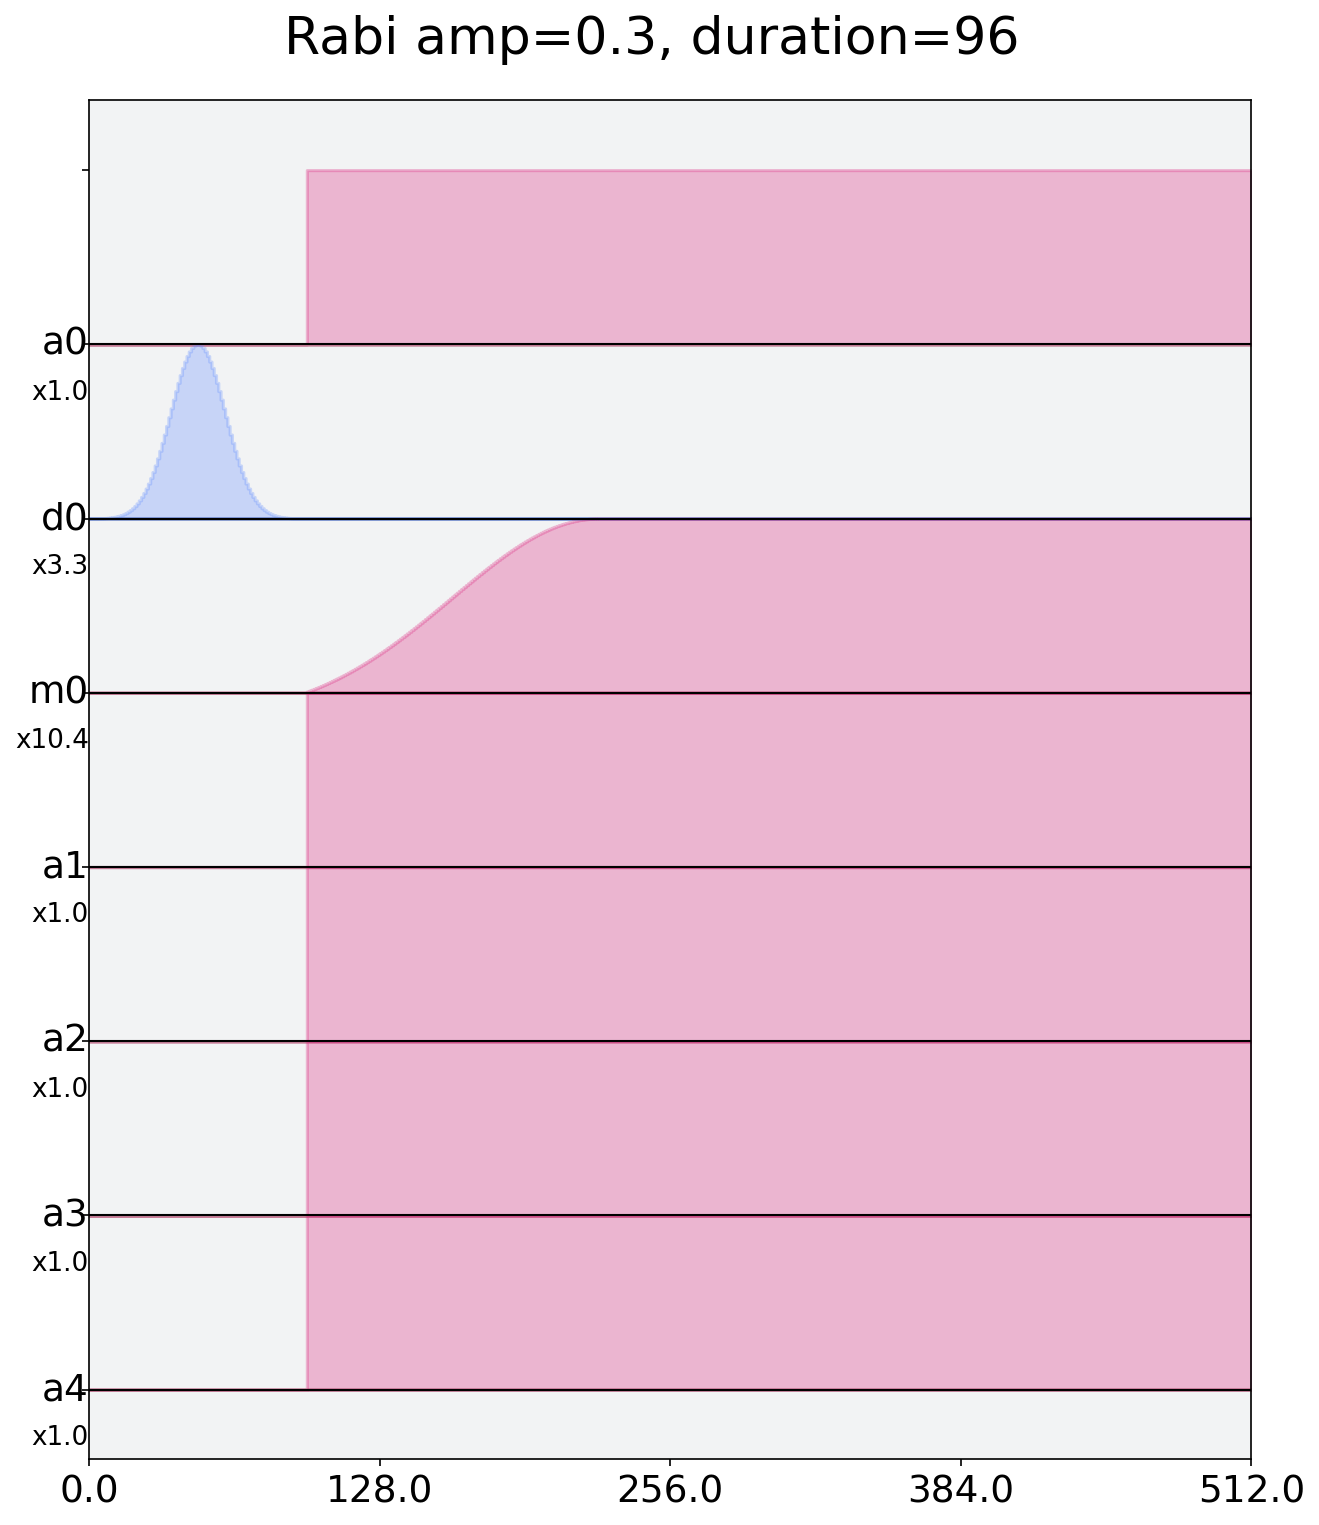

In [38]:
backend_sim = PulseSimulator()

rabi_schedules=[]
for amp in drive_amps:
    for i in range(len(drive_duration)):
        sched = pulse.Schedule(name='Rabi amp={}, duration={}'.format(amp, drive_duration[i]))
        sched += pulse.Play(library.Gaussian(int(drive_duration[i]),amp,int(drive_sigma[i])).get_waveform(),pulse.DriveChannel(qubit))
        sched += measure([qubit], backend_real) << sched.duration
        rabi_schedules.append(sched)
    
    #Assemble the qobj for job submission. 
    #When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.
rabi_schedules[0].draw(plot_range=[0,512])
#rabi_schedules[-1].draw(plot_range=[0,4096])

In [39]:
rabi_qobj = assemble(rabi_schedules,
                 backend=backend_real,
                 meas_level=1,
                 meas_return='avg',
                 shots=num_shots)
#Run the simulation:
# sim_result = backend_sim.run(rabi_qobj, armonk_model).result()
sim_result = backend_real.run(rabi_qobj).result()

/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


In [40]:
cnt_sched = 0
response  = []
for amp in drive_amps:
    resp_Amp = []
    for i in range(len(drive_duration)):
        resp_Amp.append(sim_result.get_memory(cnt_sched)[qubit])
        cnt_sched = cnt_sched + 1
    response.append(resp_Amp)    
print(len(response))

13


/home/pyserver/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


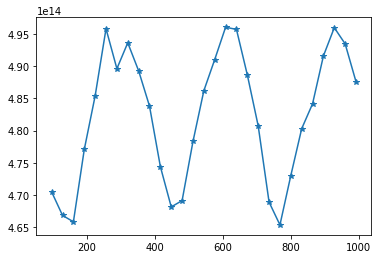

In [41]:
import matplotlib.pyplot as plt 

plt.plot(drive_duration, response[0],'-*')

In [42]:
from scipy.optimize import curve_fit
def cos_fit_func(x, A,B, w, phi):
    return B + A * np.cos(2*np.pi*x*w + phi)

def fit_Freq(x, y, xMax):
    """  [default]   xMax = 2.5

    """
    y2 = 1/np.abs(np.max(y)) * np.real(y)
    x2 = np.linspace(0, xMax, len(x))
    #plt.plot(x2, y2,'-*')

    fitparams, conv = curve_fit(cos_fit_func, x2, y2, [ 1,  0,  1, 0])
    a0, b0, w0, phi0 = fitparams
    print(' ***************** ')
    print(a0, b0, w0, phi0)
    plt.figure()
    plt.plot(x2,cos_fit_func(x2, *fitparams),'.-',x2, y2,'-*')
    
    # --------- rescaling back to the original unit  ------- #
    dT1 = x[1]   - x[0]
    dx2 = x2[1] - x2[0]
    Freq = w0 * (dx2/dT1)
    print(dx2, dT1, dx2/dT1, w0, Freq)

    return a0, b0, w0, phi0, Freq
    

# Get the 1st fine tune guess & fitting

 ***************** 
-0.05215312529582048 -0.00029029423422160914 1.1276593565114879 -0.7997553630335719
0.08928571428571429 32 0.0027901785714285715 1.1276593565114879 0.0031463709724092854


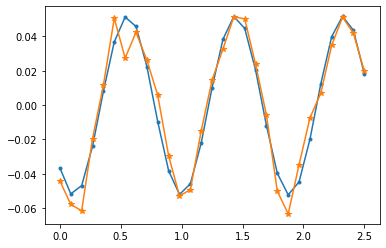

In [44]:
xMax = 2.5
response0 =  response[0] - np.mean( response[0] )
a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, response0, xMax)

fparm_List = [np.array([a0, b0, w0, phi0])]
Amp_List   = [drive_amps[0]]
w0_List     = [w0]
Freq_List   = [Freq]
xMax_List  = [xMax]

#  More schedules:  changing both Amplitude & durations

amp=0.35833333333333334, xMax_scale=2.986111111111111
amp=0.41666666666666663, xMax_scale=3.4722222222222223
amp=0.475, xMax_scale=3.958333333333333
amp=0.5333333333333333, xMax_scale=4.444444444444445
amp=0.5916666666666666, xMax_scale=4.9305555555555545


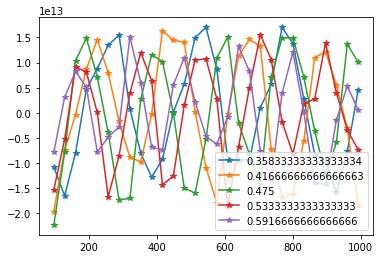

In [45]:
Look_AR = np.arange(1, 6)
#for cnt in np.arange(1, len(drive_amps)):
for cnt in Look_AR:
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp) 
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
plt.legend(drive_amps[Look_AR])

amp=0.6499999999999999, xMax_scale=5.416666666666668
amp=0.7083333333333333, xMax_scale=5.902777777777779
amp=0.7666666666666666, xMax_scale=6.38888888888889
amp=0.825, xMax_scale=6.875000000000002
amp=0.8833333333333333, xMax_scale=7.361111111111113
amp=0.9416666666666667, xMax_scale=7.847222222222224
amp=1.0, xMax_scale=8.333333333333336


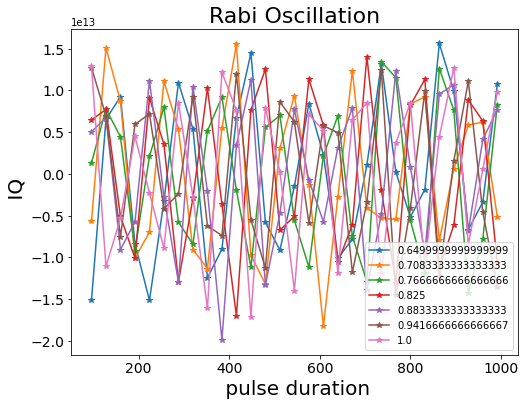

In [60]:
Look_AR = np.arange(6, len(drive_amps))
#for cnt in np.arange(1, len(drive_amps)):
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Rabi Oscillation', fontsize='22')
for cnt in Look_AR:    
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp) 
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
plt.legend(drive_amps[Look_AR])
plt.xlabel(' pulse duration', fontsize='20')
plt.ylabel(' IQ', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.savefig('Oscillation.jpg', dpi=150)
plt.show()

In [58]:
#Generate the Rabi oscillation plot and find the 𝜋-pulse amplitude:
#rabi_fit = RabiFitter(sim_result, drive_duration, [qubit], fit_p0 = [1.5, 2, 0, 0])
# plot
# rabi_fit.plot(0)

amp=0.35833333333333334, xMax_scale=2.99
 ***************** 
-0.05493826563342942 0.004195303946790597 1.1427952931151657 -0.7082206390979117
0.10664682539682539 32 0.0033327132936507935 1.1427952931151657 0.0038086090652864678
amp=0.41666666666666663, xMax_scale=3.47
 ***************** 
-0.08436312338475584 0.0024315779846579167 1.1476463046640253 -0.3319421543023489
0.1240079365079365 32 0.0038752480158730155 1.1476463046640253 0.004447414065073262
amp=0.475, xMax_scale=3.96
 ***************** 
-0.06051610984964617 -9.002186542309821e-05 1.143255098376212 -0.0545457706731266
0.14136904761904762 32 0.004417782738095238 1.143255098376212 0.005050652638845803
amp=0.5333333333333333, xMax_scale=4.44
 ***************** 
0.04296383644411886 0.001525186874087261 1.131403290850993 -2.7924116094790654
0.15873015873015875 32 0.004960317460317461 1.131403290850993 0.005612119498268816
amp=0.5916666666666666, xMax_scale=4.93
 ***************** 
0.03766965090473867 -0.0009067402511324033 1.138282

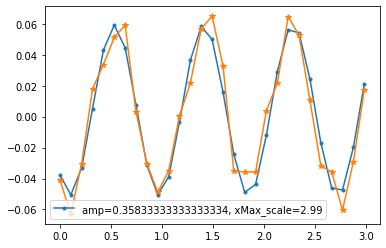

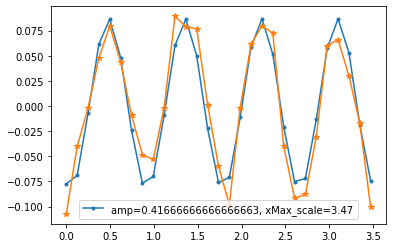

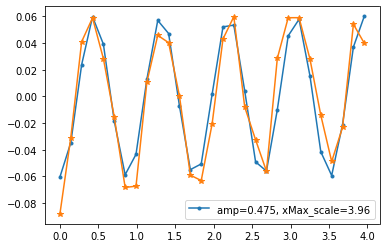

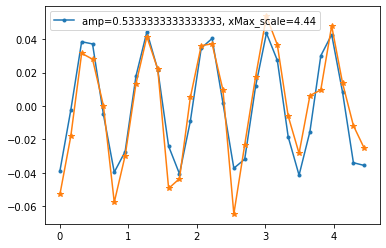

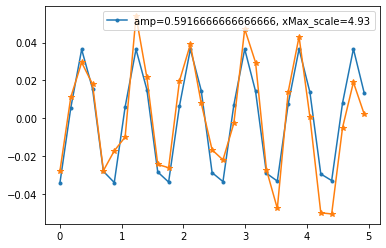

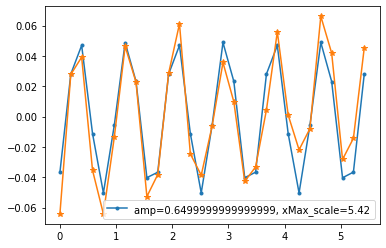

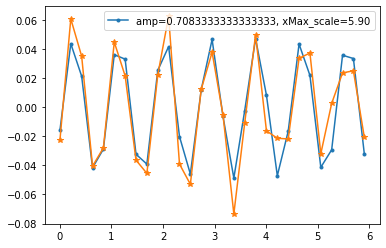

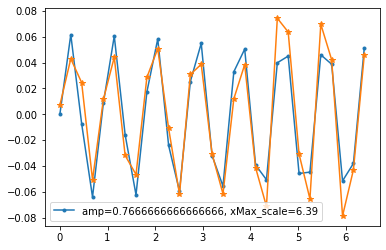

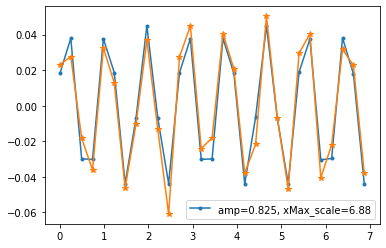

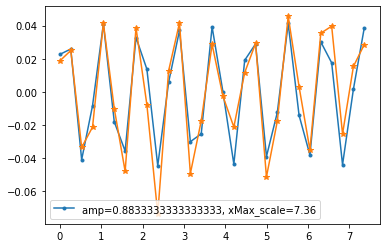

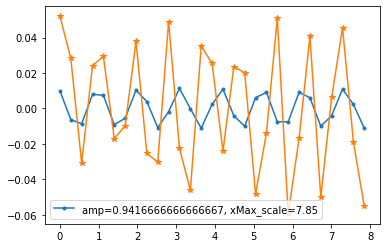

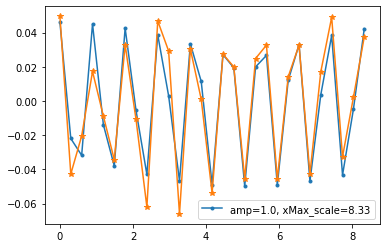

In [47]:
for cnt in np.arange(1, len(drive_amps)):
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp) 
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    str = 'amp={}, xMax_scale={:.2f}'.format(amp, xMax_scal)
    print(str)    
    
    a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, resp_Amp, xMax_scal)
    plt.legend([str])

    
    Amp_List.append(amp)
    w0_List.append(w0)
    Freq_List.append(Freq)
    xMax_List.append(xMax_scal)
    fparm_List.append(np.array([a0, b0, w0, phi0]))


In [48]:
print(Amp_List)
print(w0_List)
print(Freq_List)
print(xMax_List)
print(fparm_List)

[0.3, 0.35833333333333334, 0.41666666666666663, 0.475, 0.5333333333333333, 0.5916666666666666, 0.6499999999999999, 0.7083333333333333, 0.7666666666666666, 0.825, 0.8833333333333333, 0.9416666666666667, 1.0]
[1.1276593565114879, 1.1427952931151657, 1.1476463046640253, 1.143255098376212, 1.131403290850993, 1.1382823007937912, 1.1488476506602325, 1.1289514890224415, 1.11956719836888, 1.1112271305239427, 1.1152905748098139, 0.9433616312579167, 1.0882753327462278]
[0.0031463709724092854, 0.0038086090652864678, 0.004447414065073262, 0.005050652638845803, 0.005612119498268816, 0.006263799243269404, 0.006945228542867848, 0.007437443930346875, 0.007983025037972545, 0.008526435850839405, 0.009162698484765646, 0.008262018254909522, 0.01012160837747608]
[2.5, 2.986111111111111, 3.472222222222222, 3.9583333333333335, 4.444444444444445, 4.9305555555555545, 5.416666666666666, 5.902777777777778, 6.388888888888888, 6.875, 7.361111111111112, 7.847222222222223, 8.333333333333336]
[array([-5.21531253e-02,

In [49]:
IDsort = np.argsort(Amp_List);                  print(IDsort)
Amp_List = np.array(Amp_List)[IDsort];      print(Amp_List)
w0_List    = np.array(w0_List)[IDsort];               print(w0_List)
Freq_List  = np.array(Freq_List)[IDsort];             print(Freq_List)
xMax_List  = np.array(xMax_List)[IDsort];           print(xMax_List)
fparm_List = np.array(fparm_List)[IDsort,:];       print(fparm_List)   

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0.3        0.35833333 0.41666667 0.475      0.53333333 0.59166667
 0.65       0.70833333 0.76666667 0.825      0.88333333 0.94166667
 1.        ]
[1.12765936 1.14279529 1.1476463  1.1432551  1.13140329 1.1382823
 1.14884765 1.12895149 1.1195672  1.11122713 1.11529057 0.94336163
 1.08827533]
[0.00314637 0.00380861 0.00444741 0.00505065 0.00561212 0.0062638
 0.00694523 0.00743744 0.00798303 0.00852644 0.0091627  0.00826202
 0.01012161]
[2.5        2.98611111 3.47222222 3.95833333 4.44444444 4.93055556
 5.41666667 5.90277778 6.38888889 6.875      7.36111111 7.84722222
 8.33333333]
[[-5.21531253e-02 -2.90294234e-04  1.12765936e+00 -7.99755363e-01]
 [-5.49382656e-02  4.19530395e-03  1.14279529e+00 -7.08220639e-01]
 [-8.43631234e-02  2.43157798e-03  1.14764630e+00 -3.31942154e-01]
 [-6.05161098e-02 -9.00218654e-05  1.14325510e+00 -5.45457707e-02]
 [ 4.29638364e-02  1.52518687e-03  1.13140329e+00 -2.79241161e+00]
 [ 3.76696509e-02 -9.06740251e-04  1.1

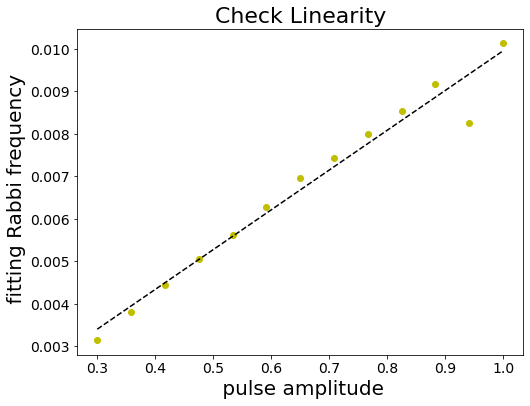

In [59]:
fit_coef   = np.polyfit(Amp_List, Freq_List, 1)
Rabi_linear  = np.poly1d(fit_coef)
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Check Linearity', fontsize='22')
plt.plot(Amp_List, Freq_List,'yo', Amp_List, Rabi_linear(Amp_List), '--k')
plt.xlabel(' pulse amplitude', fontsize='20')
plt.ylabel(' fitting Rabbi frequency', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.savefig('linearity.jpg', dpi=150)
plt.show()

In [ ]:
import csv

